# Tutorial for nyaggle
This Jupyter Notebook basic usage.

1. Intall nyaggle

## Install nyaggle
You can install nyaggle via [pip](https://pypi.org/project/nyaggle/)

In [1]:
!pip install --quiet mlflow

In [2]:
!pip install --quiet nyaggle

In [3]:
import nyaggle

nyaggle.__version__

'0.1.2'

In [4]:
import numpy as np
import pandas as pd

train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")

In [5]:
target_col = 'Survived'
target = train[target_col]
train.drop(columns=[target_col], inplace=True)

In [6]:
is_train = 'is_train'
train[is_train] = 1
test[is_train] = 0

In [7]:
data = pd.concat([train, test], sort=False).reset_index(drop=True)

In [8]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [9]:
import nyaggle.feature_store as fs

@fs.cached_feature("all_feature")
def all_feature(df: pd.DataFrame) -> pd.DataFrame:
    df['Sex'] = df['Sex'].replace(['male','female'], [0, 1])
    df['Embarked'] = df['Embarked'].fillna(('S'))
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    df['Fare'] = df['Fare'].fillna(np.mean(df['Fare']))
    df['Age'] = df['Age'].fillna(df['Age'].median())
    delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
    df = df.drop(delete_columns, axis=1)
    return df

In [10]:
_all_feature = all_feature(data)
# _embarked_feature = embarked_feature(data)

In [11]:
%ls features/

all_feature.f


In [12]:
_all_feature.head()

,Pclass,Sex,Age,Fare,Embarked,is_train
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,1
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,1


In [13]:
del _all_feature

In [14]:
_all_feature = all_feature(data)

In [15]:
train, test = _all_feature[_all_feature[is_train] == 1], _all_feature[_all_feature[is_train] == 0]
train.drop(columns=[is_train], inplace=True)
test.drop(columns=[is_train], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
from nyaggle.hyper_parameters import list_hyperparams

list_hyperparams()

[{'num_leaves': 333,
  'min_child_weight': 0.03454472573214212,
  'feature_fraction': 0.3797454081646243,
  'bagging_fraction': 0.4181193142567742,
  'min_data_in_leaf': 106,
  'objective': 'binary',
  'max_depth': -1,
  'learning_rate': 0.006883242363721497,
  'boosting_type': 'gbdt',
  'metric': 'auc',
  'reg_alpha': 0.3899927210061127,
  'reg_lambda': 0.6485237330340494},
 {'objective': 'binary',
  'metric': 'None',
  'learning_rate': 0.01,
  'num_leaves': 256,
  'max_bin': 255,
  'max_depth': -1,
  'bagging_freq': 5,
  'bagging_fraction': 0.7,
  'feature_fraction': 0.7,
  'first_metric_only': True},
 {'num_leaves': 4,
  'min_data_in_leaf': 5,
  'objective': 'fair',
  'max_depth': -1,
  'learning_rate': 0.02,
  'boosting': 'gbdt',
  'boost_from_average': True,
  'feature_fraction': 0.9,
  'bagging_freq': 1,
  'bagging_fraction': 0.5,
  'max_bin': 500,
  'reg_alpha': 0,
  'reg_lambda': 0},
 {'objective': 'gamma',
  'max_depth': -1,
  'feature_fraction': 0.025,
  'bagging_fraction': 0

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is []



Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817775
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.817775


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is []



Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.846121
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.850195


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is []



Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.855585
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.857749


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is []



Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.855088
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.855088


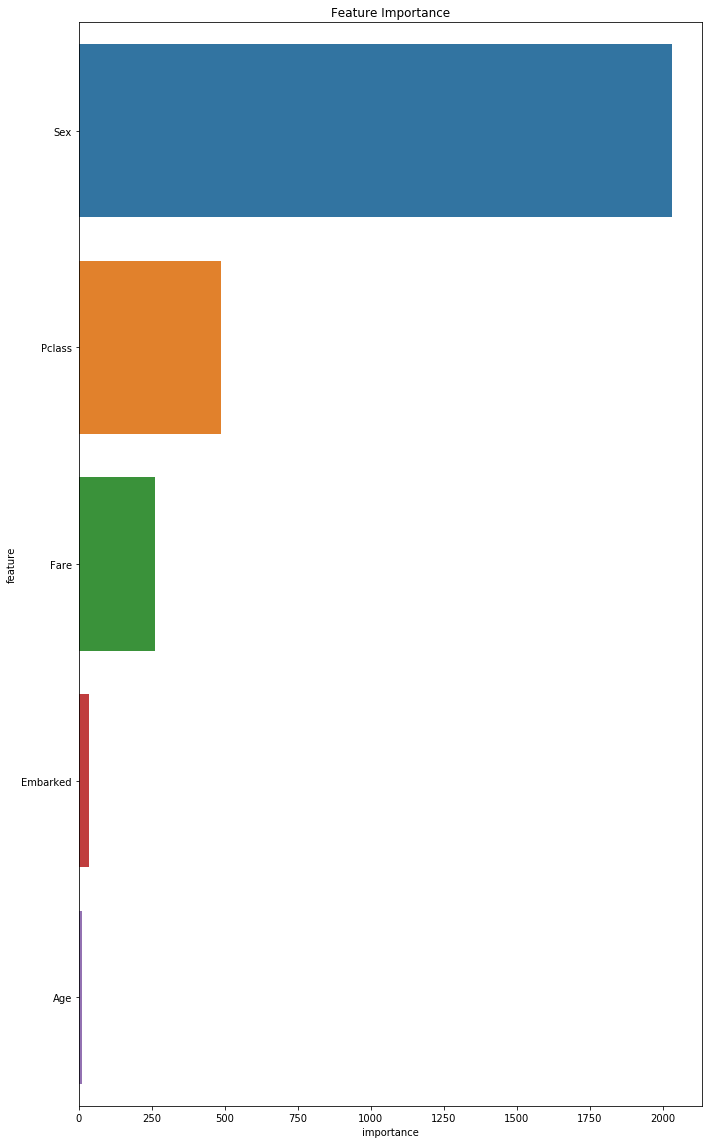

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from nyaggle.experiment import run_experiment

skf = StratifiedKFold(4)

lgb_params = {'num_leaves': 8,
  'min_data_in_leaf': 42,
  'objective': 'binary',
  'max_depth': 16,
  'learning_rate': 0.03,
  'boosting': 'gbdt',
  'bagging_freq': 5,
  'bagging_fraction': 0.8,
  'feature_fraction': 0.8201,
  'reg_alpha': 1.7289,
  'reg_lambda': 4.984,
  'metric': 'auc',
  'subsample': 0.81,
  'min_gain_to_split': 0.01,
  'min_child_weight': 19.428}

fit_params = {
    "early_stopping_rounds": 100,
    "verbose": 100
}

result = run_experiment(lgb_params,
                        train, target, test, fit_params=fit_params,
                        cv=skf, eval_func=roc_auc_score, sample_submission=gender_submission,
                        with_mlflow=True)

In [18]:
# !mlflow ui